## Install dependencies

In [1]:
!pip install nnsight matplotlib goodfire huggingface_hub scikit-learn python-dotenv -q


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


## Set HF_HOME for runpod-compatible cache

In [2]:
import os
os.environ['HF_HOME'] = '/workspace/hf'

## Set autoreload, which reloads modules when they are changed

In [3]:
%load_ext autoreload
%autoreload 2

## Load environment variables
Make sure you have a .env file with HF_TOKEN and GOODFIRE_API_KEY! Example:

HF_TOKEN=hf_foo...

GOODFIRE_API_KEY=sk-goodfire-bar...

In [4]:
from dotenv import load_dotenv
if not load_dotenv():
    raise Exception('Error loading .env file. File might be missing or empty.')

assert os.environ.get('HF_TOKEN'), "Missing HF_TOKEN in .env file"
assert os.environ.get('GOODFIRE_API_KEY'), "Missing GOODFIRE_API_KEY in .env file"

## Import dependencies

In [5]:
import goodfire

from lib.sae import download_and_load_sae
from lib.lm_wrapper import ObservableLanguageModel
from lib.utils import set_seed

## Specify which language model, which SAE to use, and which layer

In [6]:
MODEL_NAME = 'meta-llama/Meta-Llama-3.1-8B-Instruct'
SAE_NAME = 'Llama-3.1-8B-Instruct-SAE-l19'
SAE_LAYER = 'model.layers.19'
EXPANSION_FACTOR = 16 if SAE_NAME == 'Llama-3.1-8B-Instruct-SAE-l19' else 8

## Download and instantiate the Llama model

**This will take a while to download Llama from HuggingFace.**

In [7]:
model = ObservableLanguageModel(
    MODEL_NAME,
)

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## Download and instantiate the SAE

In [8]:
sae = download_and_load_sae(
    sae_name=SAE_NAME,
    d_model=model.d_model,
    expansion_factor=EXPANSION_FACTOR,
    device=model.device,
)

## Set up Goodfire Client & Pirate Feature

In [9]:
client = goodfire.Client(api_key=os.environ.get('GOODFIRE_API_KEY'))

pirate_feature_index = 58644
pirate_feature_strength = 12.0
pirate_feature = {pirate_feature_index: pirate_feature_strength}

set_seed(42)

## This cell compares two different methods of creating a steering vector from a set of activations: taking the mean, or using PCA to extract a singleprincipal component.

It does so by comparing the values of the the steering vectors in the activation space, and by comparing the non-zero values of the steering vectors in the SAE latent space.

It also does a latent-by-latent comparison of the steering vectors, including latent descriptions.

Trued up prompts to the same token length.
Neutral prompt is now: The assistant should act normally. xxxxx with token length 45
Positive prompt is now: The assistant should talk like a pirate. with token length 45
PCA explained variance ratio: [0.3281158]


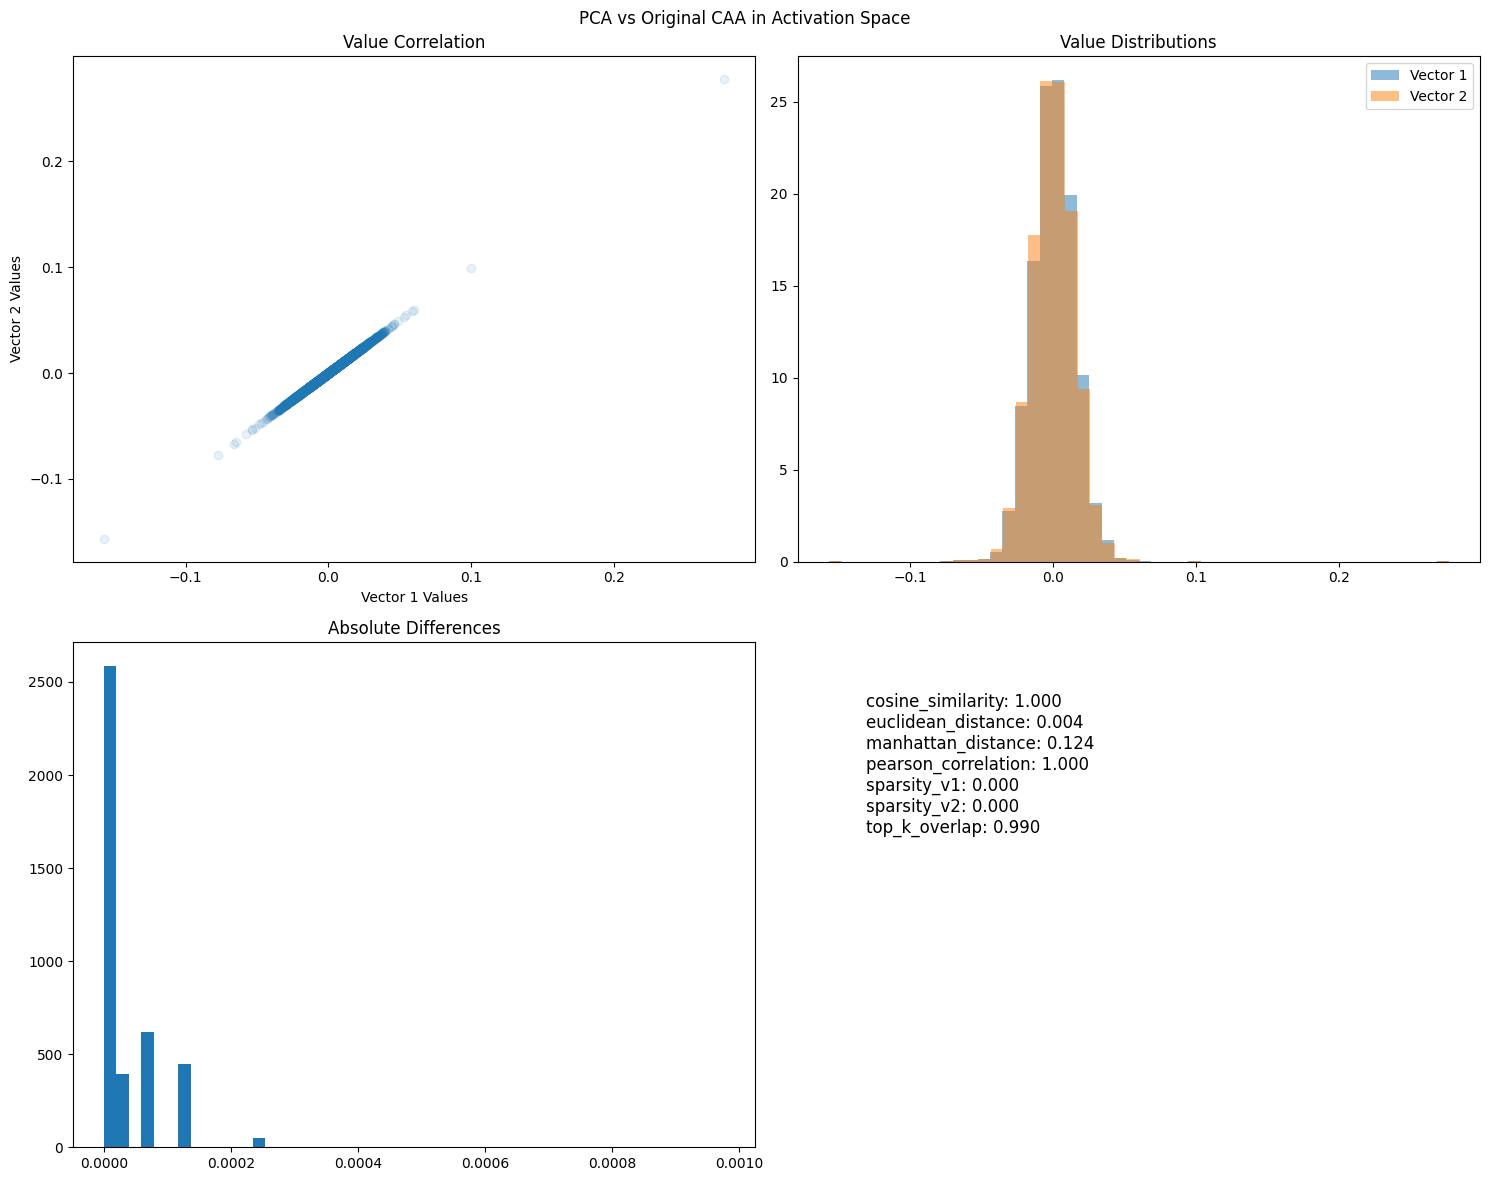

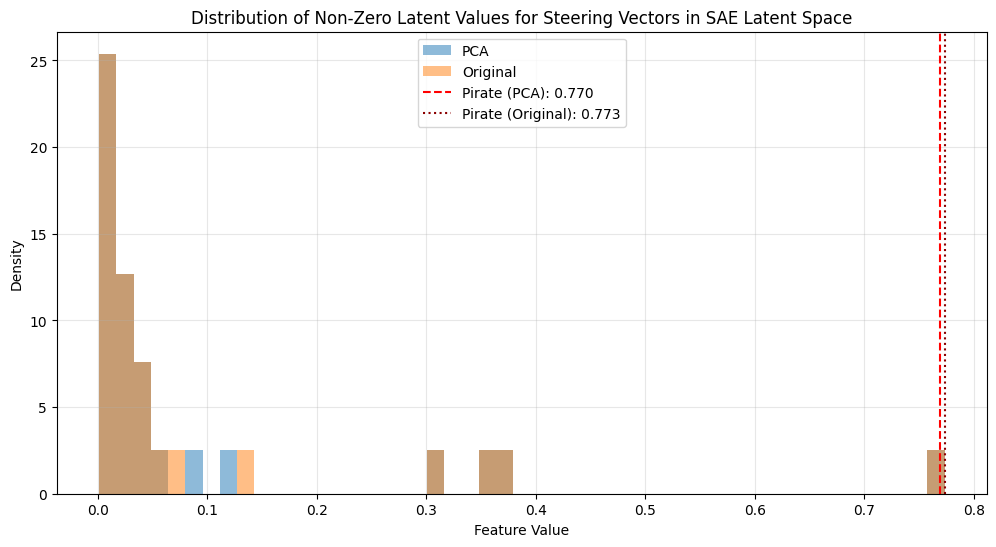


Feature descriptions (sorted by combined magnitude):
Index    PCA        Original   Delta (%)  Description
--------------------------------------------------------------------------------
58644    0.770      0.773      1          The assistant should roleplay as a pirate
^^ Pirate feature! ^^
8154     0.379      0.377      1          The assistant should modify its speaking style or persona
29446    0.363      0.363      0          The assistant should roleplay as a pirate
49626    0.307      0.307      0          Discussions and explanations of One Piece anime/manga lore
36761    0.127      0.128      1          The assistant needs to maintain appropriate boundaries
61831    0.081      0.080      1          Assistant's turn to speak in multilingual conversations
55450    0.059      0.059      0          The assistant should respond as a named character
25564    0.046      0.047      1          End of message token, particularly before potential language/topic switches
980      0.045 

In [10]:
from lib.utils import equalize_prompt_lengths, pca_experiment

positive_tokens, neutral_tokens = equalize_prompt_lengths(
    model=model,
    positive_prompt='The assistant should talk like a pirate.',
    neutral_prompt='The assistant should act normally.'
)

pca_caa_vector, original_caa_vector = pca_experiment(model, sae, client, MODEL_NAME, positive_tokens, neutral_tokens, SAE_LAYER)

# Clearly, the two methods produce extremely similar steering vectors. 

Below is a sanity check by applying the steering vectors to the model and seeing if the model's output changes. It does not.

In [11]:
from lib.chat import activation_space_caa_intervention, generate_tokens
from functools import partial

coeff = 11
mean_caa_intervention = partial(activation_space_caa_intervention, steering_vector=original_caa_vector, coeff=coeff)
pca_caa_intervention = partial(activation_space_caa_intervention, steering_vector=pca_caa_vector, coeff=coeff)

print("Mean CAA Intervention")
generate_tokens(model, intervention=mean_caa_intervention, max_length=96, layer=SAE_LAYER)
print("\n\n")
print("PCA CAA Intervention")
generate_tokens(model, intervention=pca_caa_intervention, max_length=96, layer=SAE_LAYER)

Mean CAA Intervention
Yer welcome to me hearty! Yer lookin' fer a swashbucklin' sea dog, eh? Well, I be a trusty ol' sea dog, savvy? Yer got yerself a fine day fer a chat, matey! Yer got a question or a tale to share, matey? Yer got a treasure to hoist the colors fer, or a sea shaggy tale to spin? Yer got a sea dog's ear, mate


PCA CAA Intervention
Yer welcome to me hearty! Yer lookin' fer a swashbucklin' sea dog, eh? Well, I be a trusty ol' sea dog, savvy? Yer got yerself a fine day fer a chat, matey! Yer got a question or a tale to share, matey? Yer got a treasure to hoist the colors fer, or a sea shaggy tale to spin? Yer got a sea dog's ear, mate

# This is interesting!

We would not necessarily expect that PCA and mean would produce the same steering vectors, but they do. This is despite the PCA direction only explaining 32% of the variance!